# Data Science in Psychology & Neuroscience (DSPN): 

## Lecture 15. Data Modeling (part 2)

### Date: October 15, 2020

### To-Dos From Last Class:

* Assignment #4: <a href="https://www.dropbox.com/request/QRN3YlXMeh3okGCA8SMG">Data Visualization</a> (before 10/15, 23:00 MDT)
    
### Today:

* Regression
* Correlation
* One-Way ANOVA
* Repeated measures ANOVA
* Linear Mixed-Effects Models

### Homework

* Assignment #4: <a href="https://www.dropbox.com/request/QRN3YlXMeh3okGCA8SMG">Data Visualization</a> (before 10/15, 23:00 MDT)

In [7]:
# plot theme stuff
# Many palettes available online, can customize
# these are from: https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=9
my_palette <- c("#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00")

# This is the basic function I use for all the ggplots I create. 
# Modified from this black themed ggplot function: https://gist.github.com/jslefche/eff85ef06b4705e6efbc
my_theme = function(base_size = 24, base_family = "") {
  
  theme_grey(base_size = base_size, base_family = base_family) %+replace%
    
    theme(
      # Specify axis options
      axis.line = element_blank(),  
      axis.text.x = element_text(size = base_size*0.8, color = "black", lineheight = 0.9),  
      axis.text.y = element_text(size = base_size*0.8, color = "black", lineheight = 0.9),  
      axis.ticks = element_line(color = "black", size  =  0.2),
      axis.title.x = element_text(size = base_size, color = "black", margin = margin(10, 0, 0, 0)),
      axis.title.y = element_text(size = base_size, color = "black", angle = 90, margin = margin(0, 10, 0, 0)),  
      axis.ticks.length = unit(0.3, "lines"),   
      # Specify legend options
      legend.background = element_rect(color = NA, fill = "#ffffff"),  
      legend.key = element_rect(color = "black",  fill = "#ffffff"),  
      legend.key.size = unit(2, "lines"),  
      legend.key.height = NULL,  
      legend.key.width = NULL,      
      legend.text = element_text(size = base_size*0.8, color = "black"),  
      legend.title = element_text(size = base_size*0.8, face = "bold", hjust = 0, color = "black"),
      legend.position = "right",  
      legend.text.align = NULL,  
      legend.title.align = NULL,  
      legend.direction = "vertical",  
      legend.box = NULL, 
      # Specify panel options
      panel.background = element_rect(fill = "#ffffff", color  =  NA),  
      panel.border = element_rect(fill = NA, color = "black"),  
      panel.grid.major = element_line(color = "#ffffff"),  
      panel.grid.minor = element_line(color = "#ffffff"),  
      panel.spacing = unit(2, "lines"),
      # Specify facetting options
      strip.background = element_rect(fill = "grey30", color = "grey10"),  
      strip.text.x = element_text(size = base_size*0.8, color = "black"),  
      strip.text.y = element_text(size = base_size*0.8, color = "black",angle = -90),  
      # Specify plot options
      plot.background = element_rect(color = "#ffffff", fill = "#ffffff"),  
      plot.title = element_text(size = base_size*1.2, color = "black"),  
      plot.margin = unit(rep(1, 4), "lines")
    ) 
}

# So you want to model some data...

<img src='img/decision_tree.png' width='500'>

## Table 1: Summarizing the pros / cons

| Type of Model | Distribution Assumptions | Characteristics | Sensitivity to violations |
| --- | --- | --- | --- |
| parametric | specific, inflexible | optimal when assumptions are met | Very high |
| robust | parametric, allowing some flexibility | good performance in many situations | Moderate |
| nonparametric | no assumptions | Sub-optimal, but acceptable across almost any distribution | Not at all |

* Data science in practice: 
    * If assumptions not violated, use standard parametric models. 
    * If violated a bit (often the case in psych and neuro) use robust variants.
    * If your data are truly wacky, use nonparametric models.
        * In class, only nonparametric test I'll cover is Spearman's _rho_.
   
For a thoughtful discussion on these issues: <a href="https://www.sciencedirect.com/science/article/pii/S0005796717301067">Field & Wilcox. (2017).</a>

# Questions to ask yourself:
1. What is the hypothesis you're testing?
    1. Variables?
    2. Directional?
2. Are the data going to problematic / violate GLM assumptions?
    1. Outliers? 
    2. Normality? 
    3. Equal variances?
    
* Only after understanding 1-2, test a statistical model.

# Example: Age-related changes in Fluid and Crystallized cognition in young adults

## NIH Toolbox Cognition Battery

<img src='img/nih_tb.jpg' width='500'>

* Our hypotheses: 
    1. Fluid intelligence will _decrease_ as a function of age.
    2. Crystallized intelligence will _increase_ as a function of age.

## Preamble before we get started...

In [8]:
library(tidyverse)

# loading the hcp_alldat.csv file
data <- 'misc_exercises/hcp_alldat.csv'
df <- read_csv(data)

# how many subjects do we have?
nsubs_arr = unique(df$Subject)
nsubs = length(nsubs_arr)
paste('the number of participants in the dataset is ≈',nsubs,sep=' ')

Parsed with column specification:
cols(
  .default = col_double(),
  Subject = col_integer(),
  Release = col_character(),
  Acquisition = col_character(),
  Gender = col_character(),
  Age = col_character(),
  `3T_Full_MR_Compl` = col_logical(),
  T1_Count = col_integer(),
  T2_Count = col_integer(),
  `3T_RS-fMRI_Count` = col_integer(),
  `3T_Full_Task_fMRI` = col_logical(),
  fMRI_WM_PctCompl = col_integer(),
  `3T_dMRI_Compl` = col_logical(),
  dMRI_3T_ReconVrs = col_character(),
  fMRI_3T_ReconVrs = col_character(),
  `7T_Full_MR_Compl` = col_logical(),
  `7T_RS-fMRI_Count` = col_integer(),
  `7T_RS-fMRI_PctCompl` = col_integer(),
  `7T_Full_Task_fMRI` = col_logical(),
  fMRI_Movie_Compl = col_logical(),
  fMRI_Ret_Compl = col_logical()
  # ... with 191 more columns
)

See spec(...) for full column specifications.



[1] "the number of participants in the dataset is ≈ 1112"

### Question 1A: What are my variables

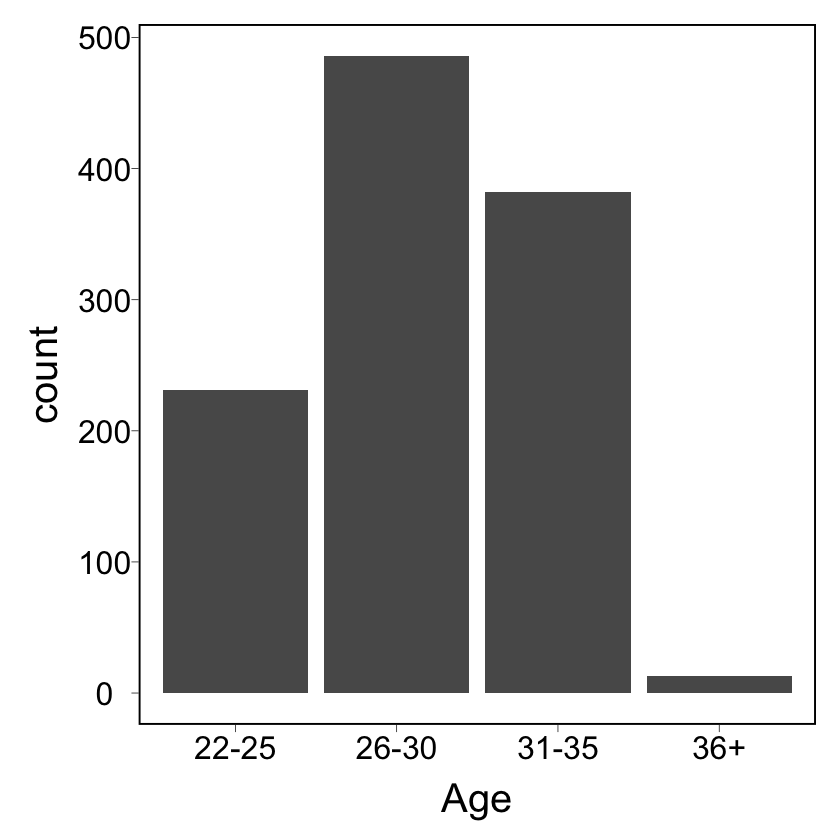

In [9]:
# What does the age variable look like?
ggplot(df,aes(x = Age)) +
    geom_bar() +
    my_theme()

# Compute ordinal age variable
df <- df %>%
    mutate(Age_ord = ifelse(Age=='22-25',1,
                           ifelse(Age=='26-30',2,3)))

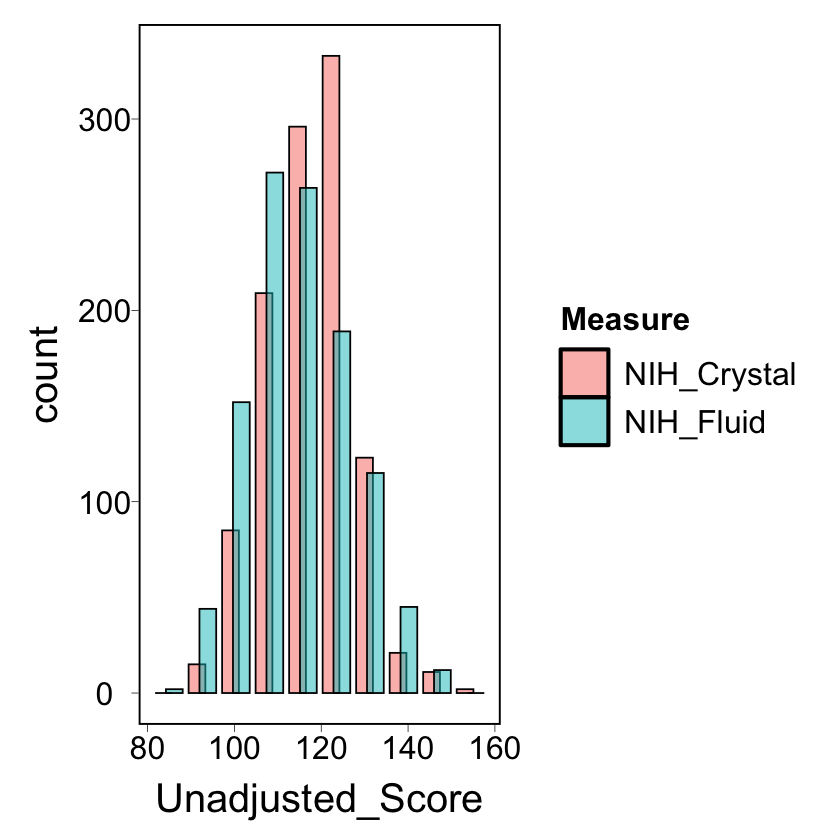

In [4]:
# visualize fluid and crystallized cog ability

plot_df <- df %>%
    select(Subject,CogCrystalComp_Unadj,CogFluidComp_Unadj) %>%
    na.omit() %>%
    rename(NIH_Fluid='CogFluidComp_Unadj',
          NIH_Crystal='CogCrystalComp_Unadj') %>%
    pivot_longer(cols = starts_with('NIH_'),
                 names_to = 'Measure',
                 values_to = 'Unadjusted_Score')

# plot a histogram of the data
ggplot(plot_df, aes(x = Unadjusted_Score, fill = Measure)) +
    geom_histogram(position=position_dodge(5),bins=10,alpha=0.5,colour='black') +
    my_theme()

### Question 1B: Directional?

* We're interested in how age and cognitive function are related. 
    * Is there a direction implicit to this question?

## Revisiting: Questions to ask yourself...
1. ~~What is the hypothesis you're testing?~~ 
<span style="background-color: #FFFF00">Our hypotheses: 1. Fluid intelligence will _decrease_ as a function of age.; 2. Crystallized intellience will _increase_ as a function of age.</span>

    1. ~~Variables?~~
    
    <span style="background-color: #FFFF00">Age, NIH-Fluid, NIH-Crystallized</span>
    
    2. ~~Directional?~~
    
    <span style="background-color: #FFFF00">NIH ~ Age</span>

<img src='img/decision_tree_dir.png' width='500'>
    
2. Are the data going to problematic / violate GLM assumptions?
    1. ~~Outliers?~~ <span style="background-color: #FFFF00">Yes, probably!</span>
    2. ___Normality?___
    3. ___Equal variances?___

In [5]:
# testing the normality of fluid cognitive ability
shapiro.test(df$CogFluidComp_Unadj)

# testing the normality of crystalized cog ability
mod <- shapiro.test(df$CogCrystalComp_Unadj)
print(mod)
# routinize which model to run based on shapiro result
if(mod$p.value<0.05){
    print('run a nonparametric or robust test!')
    # insert the model code here
}


	Shapiro-Wilk normality test

data:  df$CogFluidComp_Unadj
W = 0.98943, p-value = 4.245e-07



	Shapiro-Wilk normality test

data:  df$CogCrystalComp_Unadj
W = 0.99584, p-value = 0.004382

[1] "run a nonparametric or robust test!"


In [6]:
# Homoscedasticity across a 2-level factor
var.test(CogFluidComp_Unadj ~ Gender, data=df)

# Homoscedasticity across a k-level factor
bartlett.test(df$CogFluidComp_Unadj,df$Age_ord)
bartlett.test(df$CogCrystalComp_Unadj,df$Age_ord)


	F test to compare two variances

data:  CogFluidComp_Unadj by Gender
F = 0.87951, num df = 594, denom df = 500, p-value = 0.1337
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7427383 1.0401826
sample estimates:
ratio of variances 
         0.8795101 



	Bartlett test of homogeneity of variances

data:  df$CogFluidComp_Unadj and df$Age_ord
Bartlett's K-squared = 8.6589, df = 2, p-value = 0.01318



	Bartlett test of homogeneity of variances

data:  df$CogCrystalComp_Unadj and df$Age_ord
Bartlett's K-squared = 5.9097, df = 2, p-value = 0.05209


# Let's model the data!

* Our independent variable
    * Age
* Our dependent variables
    * NIH-Fluid
    * NIH-Crystallized
* Our model of choice
    * Regression -- Robust variant (MM-type estimators)
    * Can compare to ordinary least squares (OLS) regression model


Call:
lm(formula = CogFluidComp_Unadj ~ Age_ord, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-31.235  -8.564  -0.972   8.179  31.706 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 120.3903     1.0665 112.879  < 2e-16 ***
Age_ord      -2.4755     0.4695  -5.272 1.62e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.45 on 1094 degrees of freedom
  (16 observations deleted due to missingness)
Multiple R-squared:  0.02478,	Adjusted R-squared:  0.02389 
F-statistic:  27.8 on 1 and 1094 DF,  p-value: 1.624e-07


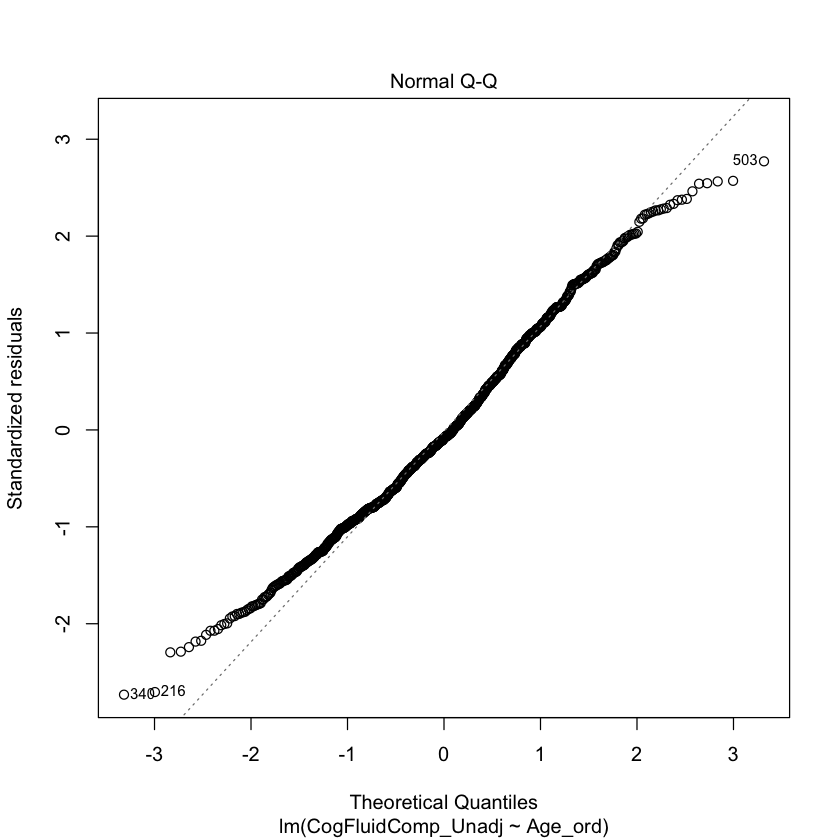

In [12]:
# Run the standard OLS lm model on fluid cognitive ability
summary(fluid_age_stdlm <- lm(CogFluidComp_Unadj ~ Age_ord, df))
plot(fluid_age_stdlm,which=2)

In [15]:
# Run the robust variant on fluid cognitive ability
# install.package('robustbase')
library(robustbase)

summary(fluid_age_stdlm <- lmrob(CogFluidComp_Unadj ~ Age_ord, df))


Call:
lmrob(formula = CogFluidComp_Unadj ~ Age_ord, data = df)
 \--> method = "MM"
Residuals:
     Min       1Q   Median       3Q      Max 
-31.1142  -8.3297  -0.7657   8.5153  32.0428 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 120.3777     1.2331  97.618  < 2e-16 ***
Age_ord      -2.5835     0.5231  -4.939 9.08e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Robust residual standard error: 11.8 
Multiple R-squared:  0.02559,	Adjusted R-squared:  0.0247 
Convergence in 9 IRWLS iterations

Robustness weights: 
 95 weights are ~= 1. The remaining 1001 ones are summarized as
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4412  0.8716  0.9474  0.9115  0.9843  0.9990 
Algorithmic parameters: 
       tuning.chi                bb        tuning.psi        refine.tol 
        1.548e+00         5.000e-01         4.685e+00         1.000e-07 
          rel.tol         scale.tol         solve.tol       eps.outlier 
        1.00


Call:
lm(formula = CogCrystalComp_Unadj ~ Age_ord, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-27.147  -6.612   0.224   6.748  36.363 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 115.6254     0.9201 125.666   <2e-16 ***
Age_ord       0.9809     0.4050   2.422   0.0156 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.89 on 1101 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.005299,	Adjusted R-squared:  0.004396 
F-statistic: 5.866 on 1 and 1101 DF,  p-value: 0.0156


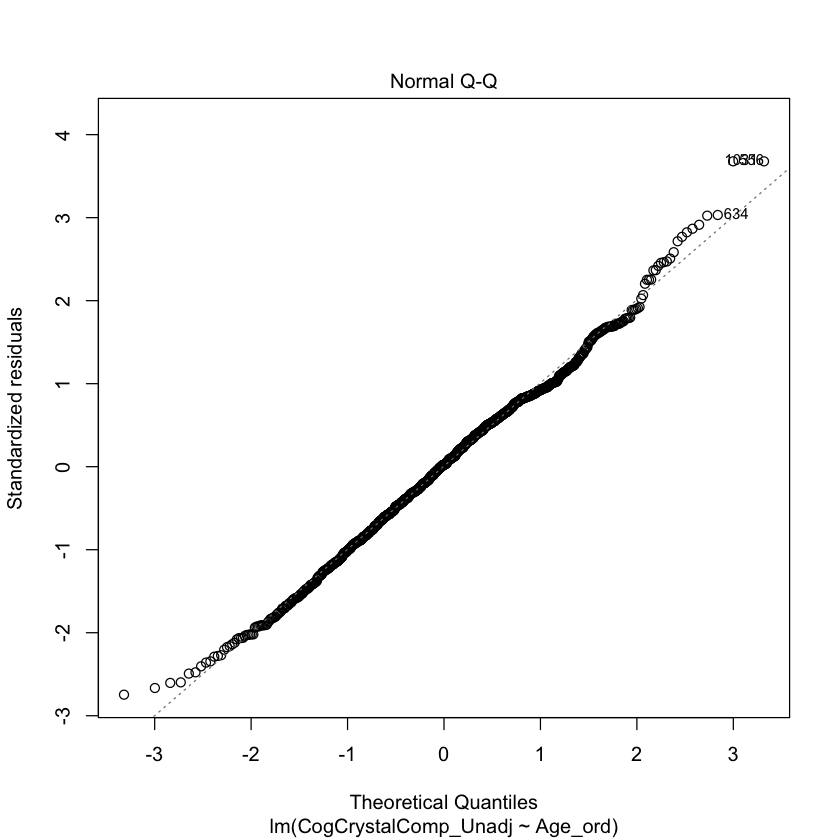

In [18]:
# Run the standard OLS lm model on crystallized cognitive ability
summary(crystal_age_stdlm <- lm(CogCrystalComp_Unadj ~ Age_ord, df))

plot(crystal_age_stdlm,which=2)


Call:
lmrob(formula = CogCrystalComp_Unadj ~ Age_ord, data = df)
 \--> method = "MM"
Residuals:
     Min       1Q   Median       3Q      Max 
-27.1018  -6.5582   0.2655   6.7646  36.4082 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 115.3473     0.9337 123.541  < 2e-16 ***
Age_ord       1.0972     0.4022   2.728  0.00647 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Robust residual standard error: 9.803 
Multiple R-squared:  0.00675,	Adjusted R-squared:  0.005848 
Convergence in 8 IRWLS iterations

Robustness weights: 
 86 weights are ~= 1. The remaining 1017 ones are summarized as
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1380  0.8798  0.9469  0.9069  0.9838  0.9990 
Algorithmic parameters: 
       tuning.chi                bb        tuning.psi        refine.tol 
        1.548e+00         5.000e-01         4.685e+00         1.000e-07 
          rel.tol         scale.tol         solve.tol       eps.outlier 
       

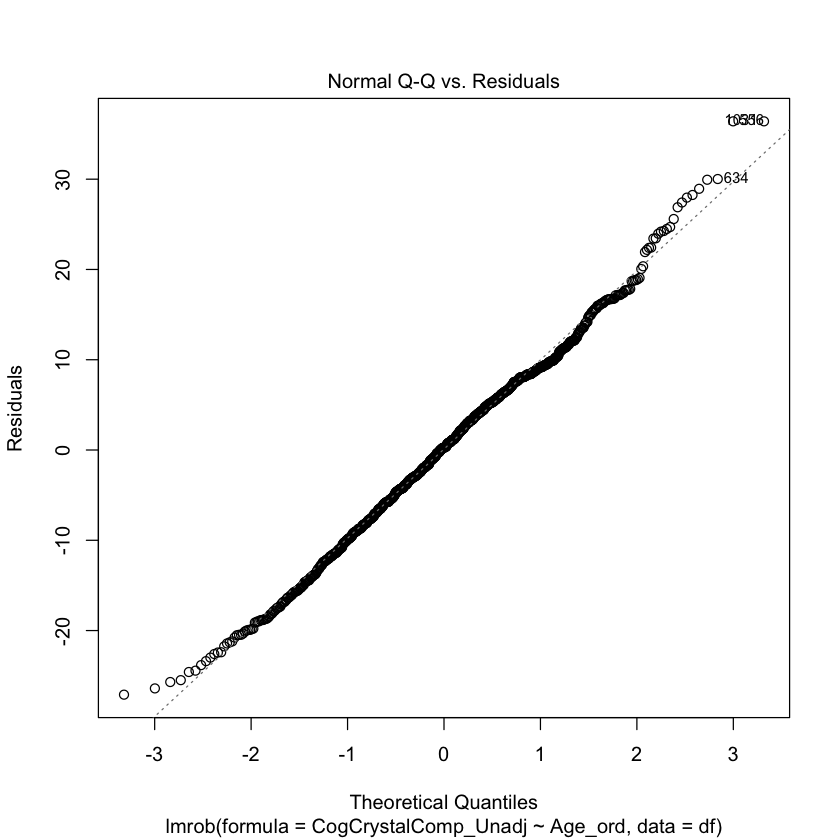

In [19]:
# Run the robust variant on crystallized cognitive ability

summary(crystal_age_roblm <- lmrob(CogCrystalComp_Unadj ~ Age_ord, df))

plot(crystal_age_roblm,which=2)

`geom_smooth()` using formula 'y ~ x'



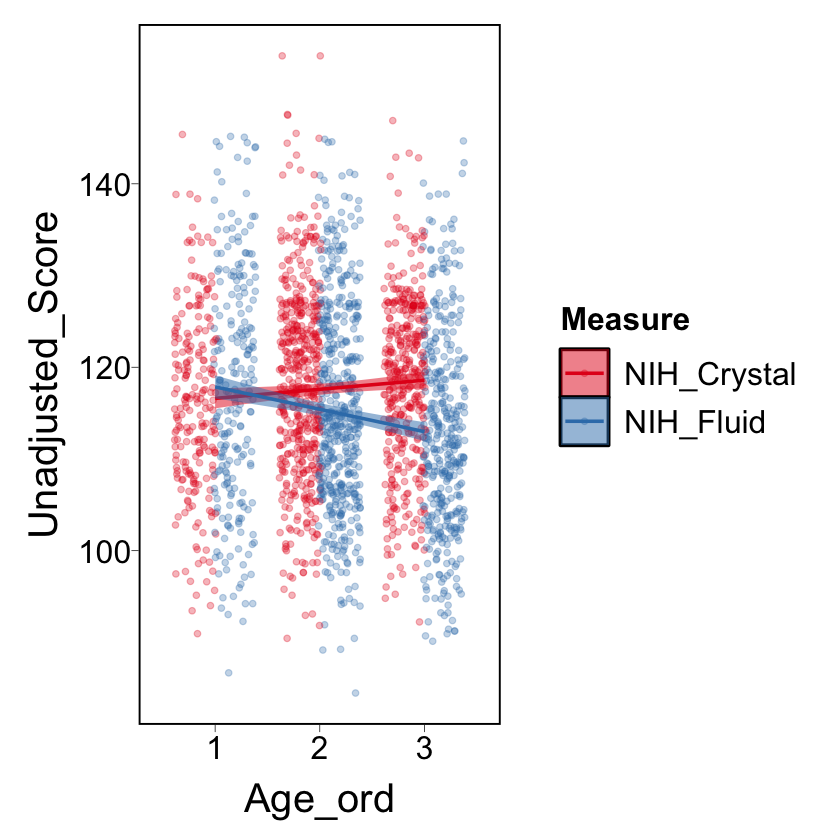

In [20]:
# visualizing the data 

# arranging the data needed
scatterplot_df <- df %>%
    select(Subject,Age_ord,CogFluidComp_Unadj,CogCrystalComp_Unadj) %>%
    na.omit() %>%
    rename(NIH_Fluid='CogFluidComp_Unadj',
          NIH_Crystal='CogCrystalComp_Unadj') %>%
    pivot_longer(cols = starts_with('NIH_'),
                names_to = 'Measure',
                values_to = 'Unadjusted_Score') 

# plotting the data
ggplot(scatterplot_df,aes(x = Age_ord,y = Unadjusted_Score,fill=Measure,colour=Measure)) +
    geom_point(position=position_jitterdodge(),alpha=0.3) +
    geom_smooth(method='lm',alpha=0.5) +
    my_theme() +
    scale_fill_manual(values=my_palette)+
    scale_colour_manual(values=my_palette)

# What if we had a covariate to include?

* e.g. Control for variance in internalizing psychopathology

In [24]:
# Run the a robust model on fluid cog ~ age + sadness

summary(fluid_age_w_cov_roblm <- lmrob(CogFluidComp_Unadj ~ Age_ord + Sadness_Unadj, df))

summary(fluid_age_w_cov_andInteraction_roblm <- lmrob(CogFluidComp_Unadj ~ Age_ord * Sadness_Unadj, df))


Call:
lmrob(formula = CogFluidComp_Unadj ~ Age_ord + Sadness_Unadj, data = df)
 \--> method = "MM"
Residuals:
     Min       1Q   Median       3Q      Max 
-31.2494  -8.1472  -0.8252   8.2374  31.7693 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   125.42224    2.45567  51.075  < 2e-16 ***
Age_ord        -2.64175    0.52315  -5.050 5.18e-07 ***
Sadness_Unadj  -0.10615    0.04464  -2.378   0.0176 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Robust residual standard error: 11.79 
Multiple R-squared:  0.03051,	Adjusted R-squared:  0.02873 
Convergence in 9 IRWLS iterations

Robustness weights: 
 77 weights are ~= 1. The remaining 1018 ones are summarized as
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4480  0.8740  0.9485  0.9132  0.9860  0.9989 
Algorithmic parameters: 
       tuning.chi                bb        tuning.psi        refine.tol 
        1.548e+00         5.000e-01         4.685e+00         1.000e-07 
  


Call:
lmrob(formula = CogFluidComp_Unadj ~ Age_ord * Sadness_Unadj, data = df)
 \--> method = "MM"
Residuals:
     Min       1Q   Median       3Q      Max 
-31.2351  -8.1663  -0.8108   8.2780  31.7404 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           124.21223    7.80407  15.916   <2e-16 ***
Age_ord                -2.08171    3.30270  -0.630    0.529    
Sadness_Unadj          -0.08019    0.16415  -0.489    0.625    
Age_ord:Sadness_Unadj  -0.01205    0.06965  -0.173    0.863    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Robust residual standard error: 11.79 
Multiple R-squared:  0.03049,	Adjusted R-squared:  0.02783 
Convergence in 10 IRWLS iterations

Robustness weights: 
 79 weights are ~= 1. The remaining 1016 ones are summarized as
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4488  0.8724  0.9486  0.9131  0.9859  0.9990 
Algorithmic parameters: 
       tuning.chi                bb        tuning.p

# What if we didn't have a directional prediction?

* e.g. Association between fluid and crystallized

<img src='img/decision_tree_undir.png' width='500'>

In [36]:
# Run a standard correlation between fluid and crystallized
x1var <- df$CogCrystalComp_Unadj
# print(x1var)
x2var <- df$CogFluidComp_Unadj
# print(x2var)
print(cor.test(x1var,x2var))


	Pearson's product-moment correlation

data:  x1var and x2var
t = 12.081, df = 1093, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2898786 0.3944475
sample estimates:
      cor 
0.3432261 



In [37]:
# Run a ranked correlation between fluid and crystallized
print(cor.test(x1var,x2var,method='spearman'))

Warning message in cor.test.default(x1var, x2var, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  x1var and x2var
S = 148800000, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3199949 



# What if we wanted to make a specific inference about group __differences__?

* e.g. Which age group differs from the others wrt fluid intelligence?

<img src='img/decision_tree_diffs.png' width='500'>

In [39]:
# Standard parametric One-way ANOVA on Fluid Intelligence
summary(fluid_age_stdanova <- aov(CogFluidComp_Unadj ~ Age_ord,df))

#  Planned comparisons on one-way ANOVA
print(fluid_age_stdcomp <- pairwise.t.test(df$CogFluidComp_Unadj,df$Age_ord,p.adjust.method='holm'))

              Df Sum Sq Mean Sq F value   Pr(>F)    
Age_ord        1   3645    3645    27.8 1.62e-07 ***
Residuals   1094 143448     131                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
16 observations deleted due to missingness


	Pairwise comparisons using t tests with pooled SD 

data:  df$CogFluidComp_Unadj and df$Age_ord 

  1       2      
2 0.02790 -      
3 1.3e-06 0.00063

P value adjustment method: holm 


### Let's also try a Robust Bootstrap version of the one-way ANOVA...
* Test the hypothesis of equal __trimmed__ means using a bootstrap method.
    * https://rdrr.io/rforge/WRS2/man/t1waybt.html

In [43]:
# install.packages('WRS2')
library(WRS2)

# Robust One-way ANOVA on Fluid Intelligence
print(fluid_age_robanova <- t1waybt(CogFluidComp_Unadj ~ Age_ord,df,tr=0.2,nboot=1000))

# Robust planned comparisons on one-way ANOVA
print(fluid_age_robcomp <- mcppb20(CogFluidComp_Unadj ~ Age_ord,df,tr=0.2,nboot=1000))

Call:
t1waybt(formula = CogFluidComp_Unadj ~ Age_ord, data = df, tr = 0.2, 
    nboot = 1000)

Effective number of bootstrap samples was 1000.

Test statistic: 12.1987 
p-value: 0 
Variance explained 0.045 
Effect size 0.213 

Call:
mcppb20(formula = CogFluidComp_Unadj ~ Age_ord, data = df, tr = 0.2, 
    nboot = 1000)

         psihat ci.lower ci.upper p-value
2 vs. 3 2.53373 -0.13396  5.52163   0.038
2 vs. 1 5.41135  2.47029  8.31358   0.000
3 vs. 1 2.87762  0.92142  4.77700   0.002



# Repeated-Measures ANOVA

* e.g. Testing for age-related changes on specific fluid cog subscales

* Repeated-Measures ANOVA with a bw subjects factor

| Participant | Age | flexibility (DCCS) | inhibition (Flanker) |
| --- | --- | --- | --- |
| S1 | S1_Age | S1_DCCS |  S1_Flanker |
| S2 | S2_Age | S2_DCCS |  S2_Flanker |
| ... | ... | ... | ... |
| Sn | Sn_Age | Sn_DCCS |  Sn_Flanker |

Subject,Age_ord,CardSort_Unadj,Flanker_Unadj
<int>,<dbl>,<dbl>,<dbl>
100206,2,119.14,130.42
100307,2,123.75,112.56
100408,3,111.14,121.18
100610,2,129.84,126.53
101006,3,105.19,101.85
101107,1,119.76,107.04



 REPEATED MEASURES ANOVA

 Within Subjects Effects                                                                                  
 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 
                        Sum of Squares    df      Mean Square    F              p             η²-p        
 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 
   NIH_Fluid                5489.79818       1     5489.79818    107.2440438    < .0000001    0.0883217   
   NIH_Fluid:Age_ord          83.36095       2       41.68048      0.8142344     0.4432434    0.0014689   
   Residual                56667.07788    1107       51.18977                                             
 ──────────────────────────────────────────────────────────────────────────────────────────────────────── 
   Note. Type 3 Sums of Squares


 Between Subjects Effects                                                          

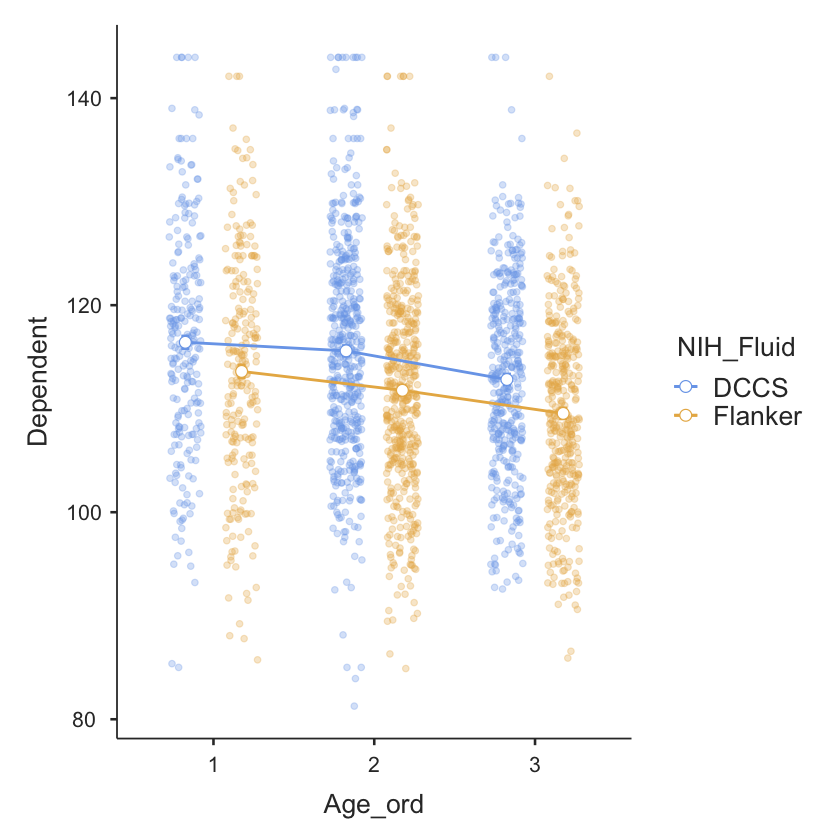

In [45]:
# install.packages('jmv')
library(jmv)

# subsetting the data we need for the rm-anova
rmanova_df <- df %>%
    select(Subject,Age_ord,CardSort_Unadj,Flanker_Unadj) 
head(rmanova_df)
# legitimately the cleanest approach to running rm-anova in R that I know of...
print(anova_rm <- anovaRM(data = rmanova_df,
                            rm = list(
                                list(label = "NIH_Fluid",
                                    levels = c("DCCS","Flanker"))),
                            rmCells = list(
                                list(measure = "CardSort_Unadj",
                                    cell = "DCCS"),
                                list(measure = "Flanker_Unadj",
                                     cell = "Flanker")),
                            bs = Age_ord,
                            effectSize = "partEta",
                            rmTerms = ~ NIH_Fluid,
                            bsTerms = ~ Age_ord,
                            leveneTest = TRUE,
                            emMeans = ~ Age_ord:NIH_Fluid,
                            emmTables = TRUE,
                            emmPlotData = TRUE,
                            emmPlotError = "se"))

<img src='img/LMMs.png' width='500'>

Wonderful (relatively brief) intro lecture: https://www.youtube.com/watch?v=QCqF-2E86r0

## Things that often muck up regression and rm-anova 
* Inability to accommodate 
* Nested factors (e.g. stimulus identity:condition, participant:testing site, etc.)
* Missing data & unbalanced designs (e.g. if we had test-retest on some but not all subjects)
* Repeats as a continuous factor (e.g. time for longitudinal studies)

## LMMs are more flexible, but a bit more esoteric


* Incorporate fixed and random effects. 
    * Fixed:  Data has been gathered from all levels that are of interest.
        * Example: N-back 2 vs 0 -- We don't intend to say anything about 3-back.
        * Indicators:
            * Primary independent variable(s) of interest.
            * Secondary covariates you want to control for (e.g. demographic vars).
            * Only has 2 levels.
    * Random: If the levels of a factor are randomly sampled from a population, it is random.
        * Example: Subject, testing site, etc.
        * Indicators:
            * Not of interest, but want to account for variance.
            * Want to generalize conclusions to entire population.
            * Any interaction with a random factor.

## Interpretation
* The model designates that the slope and intercept of the regression line are fixed by the pooled data.
    * Fixed effects intercept and coefficients pooled across random FX.
* Random effect intercepts and slopes allowed to vary randomly.
    * In lmer output, we only get information about the extent of variance.
    * <a href="https://www.rdocumentation.org/packages/lme4/versions/1.1-23/topics/ranef">ranef</a> for more info. on random FX.
    
## We can also do a robust variant of the LMM...